# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [1]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

documents = dataset.data

print(len(documents))
documents[3]

11314


'Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it?  ATT\'s last product in this area (a) was priced over\n$1000, as I suspect \'clipper\' phones will be; (b) came to the customer \nwith the key automatically preregistered with government authorities. Thus,\naside from attempting to further legitimize and solidify the fed\'s posture,\nClipper seems to be "more of the same", rather than a new direction.\n   Yes, technology will eventually drive the cost down and thereby promote\nmore widespread use- but at present, the man on the street is not going\nto purchase a $1000 crypto telephone, especially when the guy on the other\nend probably doesn\'t have one anyway.  Am I missing something?\n   The real question is what the gov will do in a year or two when air-\ntight voice privacy on a phone line is as close as your nearest pc.  That\nhas got to a problematic scenario for them, even if the extent of usage\nnever surpasses the \'underground\' stature

In [3]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text = re.sub(pattern, '', d)
  return text

def clean_stopword(d):
  stop_words=  stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [5]:
news_df.replace("", float('NaN'), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [6]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [7]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased disagree statement...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [8]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [10]:
import numpy as np

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <=1 ]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10939


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000)

idx2word = {value:key for key, value in tokenizer.word_index.items()}
sequences = tokenizer.texts_to_sequences(news_2000)


In [13]:
vocab_size = len(tokenizer.word_index) +1
print(vocab_size)

29706


In [14]:
print(sequences[1])

[1232, 443, 2, 56, 113, 405, 57, 1342, 20, 65, 3454, 384, 6822, 1142, 360, 2217, 444, 55, 12419, 444, 1862, 3804, 384, 20, 9, 4279, 8694, 171, 291, 130, 148, 648, 12420, 304, 12421, 14, 12422, 4, 770, 12423, 12424, 4870, 8695]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [17]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size =vocab_size, window_size=10) for sample in sequences[:10]]

In [20]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(5):
  print("{:s}({:d}), {:s}({:d}) - > {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

europeans(3453), sunwise(20501) - > 0
atrocities(4868), moonroof(7066) - > 0
statement(433), slap(3429) - > 0
realize(937), media(483) - > 1
look(68), hmolike(27365) - > 0


In [22]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2220
2220


In [23]:
skip_grams = [skipgrams(sample, vocabulary_size =vocab_size, window_size=10) for sample in sequences]

#### Skipgram 모델 구성

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [25]:
embed_size =50

In [34]:
def word2vec():
  target_inputs = Input(shape=(1, ), dtype=('int32'))
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1, ), dtype=('int32'))
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1, ), input_shape=(1,1))(dot_product)
  output = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs, context_inputs], outputs = output)

  model.compile(loss = 'binary_crossentropy',
                optimizer='adam')
  
  return model

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        1485300     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        1485300     input_10[0][0]                   
_______________________________________________________________________________________

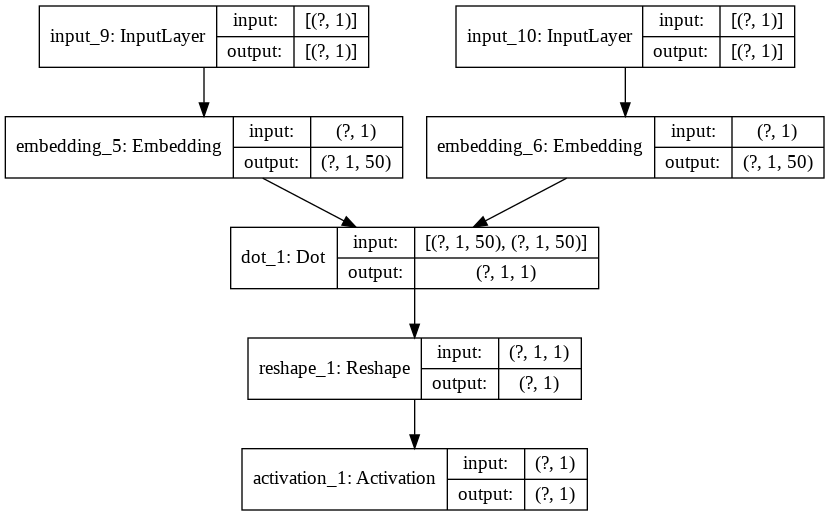

In [36]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [41]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss', loss)

Epoch: 1 Loss 972.2642656937242
Epoch: 2 Loss 851.4950505569577
Epoch: 3 Loss 798.163451127708
Epoch: 4 Loss 768.2825673148036
Epoch: 5 Loss 746.9759615138173
Epoch: 6 Loss 726.7394128292799
Epoch: 7 Loss 703.890617236495
Epoch: 8 Loss 676.3940418101847
Epoch: 9 Loss 643.9778261519969
Epoch: 10 Loss 607.2780563682318


In [43]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors  = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram  = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

In [44]:
skipgram.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('traps', 0.9072477221488953),
 ('booby', 0.8729120492935181),
 ('retalliates', 0.8505773544311523),
 ('indiscriminately', 0.8382602334022522),
 ('ammunitions', 0.823685884475708),
 ('sneak', 0.8008723258972168),
 ('villages', 0.6771853566169739),
 ('occupying', 0.6469702124595642),
 ('patrols', 0.6314089298248291),
 ('pilots', 0.623169481754303)]

In [45]:
skipgram.most_similar(positive=['world'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('scientific', 0.6852715015411377),
 ('baggage', 0.6845344305038452),
 ('today', 0.6687383651733398),
 ('revolutionary', 0.6448808908462524),
 ('wishes', 0.6393035650253296),
 ('petroleum', 0.6372166872024536),
 ('idiots', 0.6262120604515076),
 ('brudda', 0.6232374906539917),
 ('palace', 0.6202160120010376),
 ('lost', 0.6193081140518188)]

### CBOW


#### CBOW 전처리

In [61]:
def skipgram2cbow(skipgrams):
  cbows = []
  flag =0
  for n in skipgrams:
    temp1 = []
    for t in n:
      if flag ==1:
        flag = 0
        temp1.append(t)
      else:
        flag =1
        temp2 = []
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
    cbows.append(temp1) 
  
  return cbows



In [62]:
cbows = skipgram2cbow(skip_grams)

In [53]:
pairs, labels = cbows[0][0], cbows[0][1]

for i in range(5):
  print("{:s}({:d}), {:s}({:d}) - > {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

degree(1397), reason(196) - > 1
glrelated(12727), incidences(8690) - > 0
incidences(8690), israels(3452) - > 1
races(8693), guilt(6821) - > 1
shame(3177), reason(196) - > 1


In [55]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2220
2220


#### CBOW 모델 구성

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        1485300     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        1485300     input_12[0][0]                   
_______________________________________________________________________________________

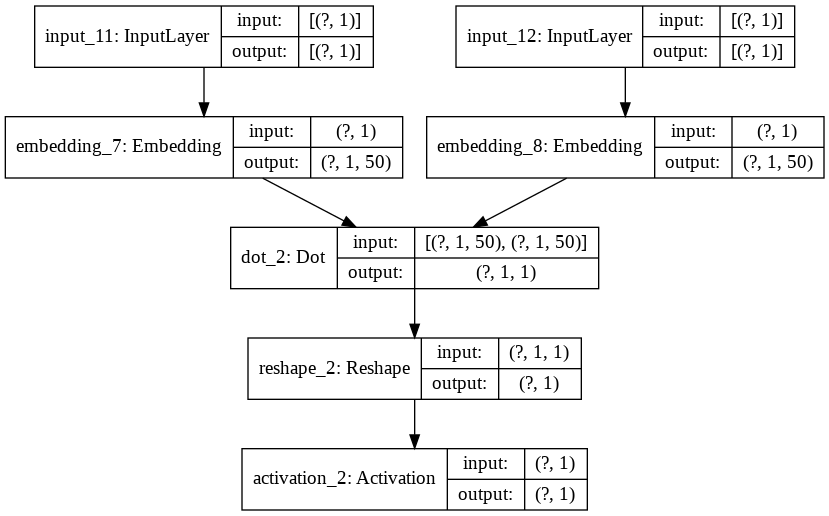

In [56]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [60]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)
  
  print('Epoch:', epoch, 'Loss', loss)

Epoch: 1 Loss 880.9561045616865
Epoch: 2 Loss 810.7095699831843
Epoch: 3 Loss 775.7478522509336
Epoch: 4 Loss 752.8940892666578
Epoch: 5 Loss 732.5395731702447
Epoch: 6 Loss 709.8901649713516
Epoch: 7 Loss 682.3713240809739
Epoch: 8 Loss 649.7735265083611
Epoch: 9 Loss 612.7165841385722
Epoch: 10 Loss 573.3709145747125


In [66]:
import gensim

f = open('cbows.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors  = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

cbows  = gensim.models.KeyedVectors.load_word2vec_format('cbows.txt', binary=False)

In [67]:
cbows.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('retalliates', 0.9592360854148865),
 ('traps', 0.9474852085113525),
 ('indiscriminately', 0.933784008026123),
 ('pilots', 0.9288116693496704),
 ('booby', 0.9156002998352051),
 ('ammunitions', 0.9084500670433044),
 ('axes', 0.9013311862945557),
 ('accustomed', 0.901064395904541),
 ('wrongly', 0.8994152545928955),
 ('bloodshed', 0.8962634205818176)]

In [68]:
cbows.most_similar(positive=['world'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('would', 0.9319173097610474),
 ('used', 0.931628406047821),
 ('going', 0.930124044418335),
 ('didnt', 0.9271249771118164),
 ('rather', 0.9237181544303894),
 ('heard', 0.9235696792602539),
 ('life', 0.9228113293647766),
 ('things', 0.9227809906005859),
 ('numbers', 0.9226273894309998),
 ('doesnt', 0.9224579334259033)]